<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:
* It is expected for the user to be familiar with Python.
* It is expected, that **MSG MDFVC** product data is saved locally. Download it from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFVC/NETCDF/) in `NetCDF4` format for the following period: 17 June 2016 - 30 November 2023.
* It is expected, that **MSG FRP - Pixel** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFVC/NETCDF/) in `HDF5` format for the following periods: 17 June 2017 - 17 July 2017 and 7 July 2022 - 5 September 2022.
</div>



<hr>

# Analyzing Effects of Wildfires on Vegetation Using LSA SAF MDFVC and MSG-FRP Pixel Productst

#### About

South Europe is prone to the occurrence of large wildfires that have serious impacts at the socio-economic and ecological levels. 
The Mediterranean climate, characterized by hot, dry summers and mild, wet winters, creates favorable conditions for the outbreak and rapid spread of fires, exacerbated by factors such as drought, high temperatures, and strong winds. Therefore, a reliable detection of fires as well as an estimation of their severity and impact is of great importance when addressing the risk posed by wildfires.

The aim of this Jupyter Notebook (JN) is to analyze the released power and evolution of the three larger wildfires that raged in the years 2017 and 2022. We will also assess their effects on vegetation. Firstly, LSA SAF Fire Radiative Power Pixel Product [LSA SAF FRPPixel [502]](https://landsaf.ipma.pt/en/data/products/fire-products/) was used to calculate the total released firepower of the fires. Then, the Fraction of Vegetation Cover [LSA SAF MDFVC [421]](https://landsaf.ipma.pt/en/data/products/vegetation/) product was used to detect potential impacts on vegetation since FVC is a helpful indicator of the state of the vegetation.

#### How to Access the Data

For this example, Fraction of Vegetation Cover (FVC) measurements (1 November 2015 - 30 November 2023) and  Fire Radiative Power (FRP) measurements (17 June 2017 - 17 July 2017 and 7 July 2022 - 5 September 2022) need to be obtained. The MDFVC product is available as `NetCDF4` as well as `HDF5` file while FRPPixel is only available as a `HDF5` file. We will download MDFVC files in the `NetCDF4`format and FRPPixel files in the `HDF5` format. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration.

Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program.

#### Basic facts on the LSA SAF MDFVC
> **Product number**: LSA-421
>
> **Spatial resolution**: 3km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 1 day
> 
> **Data availability**: from 2016
>

#### Basic facts on the LSA SAF FRPPixel
> **Product number**: LSA-502
>
> **Spatial resolution**: 3km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 15 min
> 
> **Data availability**: from 2016
> 


#### Module outline:
* [1 - Accessing the Data](#First)
* [2 - Analyzing Effects of the Wildfires on Vegetation](#Second)
* [3 - Plotting Fire Radiative Power and Fraction of Vegetation Cover](#Third)

<hr>

#### Load required libraries

In [1]:
import h5py                           # a library for working with HDF5 file formats.
import numpy as np                    # a library that lets us work with arrays; we import this with a new name "np"
import pandas as pd                   # a library for time series analysis
import datetime as dt                 # a library that allows us to work with dates and times
import xarray as xr                   # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib.pyplot as plt       # a library the provides plotting capability
from tqdm import tqdm                 # a library to display progress meter with low overhead

#### Defining Utility Functions

In this section, we will define multiple functions that will be used throughout this JN.

LSA SAF products are named following a distinct naming convention. In order to make code clearer we define functions `HDF5_FRP_name()` and `NETCDF4_FVC_name()` functions, that return the names of the FRPPixel and MDFVC products at a given time. The `HDF5_FRP_name()` returns the name of the `HDF5` file, since the FPR product is only available in this format, while the `NETCDF4_FVC_name()` returns the name of the `NetCDF4` file.

In [2]:
def HDF5_FRP_name(time):
    '''
    Returns the name of LSA SAF MSG FRP List Pixel product
    HDF5 file from particular day and time.
    '''
    HDF5_name=FRP_LOCATION+"HDF5_LSASAF_MSG_FRP-PIXEL-ListProduct_MSG-Disk_"+time.strftime('%Y%m%d%H%M')
    return HDF5_name

In [3]:
def NETCDF4_FVC_name(time):
    '''
    Returns the name of LSA SAF MSG FVC product
    NetCDF4 file from particular day and time.
    '''
    NetCDF4_name=FVC_LOCATION+"NETCDF4_LSASAF_MSG_FVC_MSG-Disk_"+time.strftime('%Y%m%d%H%M')+".nc"
    return NetCDF4_name

<a name="get_HDF5_FRP_data"></a>
In the next step, we will define the function `get_HDF5_FRP_data()`. This function opens the FRP product in `HDF5` format and exports its content as a `pandas.DatFrame`. Accessing and opening `HDF5` files is achieved by using the `h5py` library.

The `HDF5` file type often consists of multiple datasets. Specifically for the FRPPixel product, it provides a list of all pixels where the fires were detected, together with the properties of the detected fire (e.g., FRP), as well as some other attributes.

We define a function that exports a list of datasets as a `pandas.DataFrame` to simplify future work. One dimensional datasets from the `HDF5` file are exported as columns of a new `pandas.DataFrame`, which is more practical in this case.

In [4]:
def get_HDF5_FRP_data(HDF5_filename, dataset_names):
    '''
    This function returns 1D Datasets of HDF5 file as a pd. dataframe
    '''
    # Create empty pd dataframe
    df=pd.DataFrame()

    # Load HDF5 file
    file=h5py.File(HDF5_filename, 'r')


    #Loop over datasets of the interest
    for i in range(len(dataset_names)):
        dset=file[dataset_names[i]]
        df[dataset_names[i]]=dset[:]*(1/dset.attrs["SCALING_FACTOR"])

    return df

We will also define the `calculate_total_FRP()` function, which estimates the total FRP within a specified latitude-longitude rectangle at the time of the interest. Function calls `get_HDF5_FRP_data()` function and extracts information on the active fire pixels (in case they exist); FRP, FRP uncertainty as well as latitude and longitude of the fire. Consequently, the pixels outside the pre-defined latitude-longitude rectangle are filtered out and the FRP values of all remaining pixels are summed to obtain the total FRP inside the specified area.

In [5]:
def calculate_total_FRP(date, lat_min, lat_max, lon_min, lon_max):
    '''
    Function calculates total fire radiation power inside rectangle
    (lat_min-lat_max x lon_min-lon_max). 
    date=pd.datetime object
    output=Total FRP [MW]
    '''
    # Get a dataset of all pixels with active fire
    FRP_dataset=get_HDF5_FRP_data(HDF5_FRP_name(date), ["FRP", "FRP_UNCERTAINTY", "LATITUDE", "LONGITUDE"])

    # Drop entries with lat outside the range
    FRP_dataset=FRP_dataset[(FRP_dataset['LATITUDE'] > lat_min) & (FRP_dataset['LATITUDE'] < lat_max)]

    # Drop entries with lon outside the range
    FRP_dataset=FRP_dataset[(FRP_dataset['LONGITUDE'] > lon_min) & (FRP_dataset['LONGITUDE'] < lon_max)]
    
    # Sum all remaining FRP walues to get total FRP
    total_FRP=np.sum(FRP_dataset["FRP"].to_numpy())
    
    return(total_FRP)

<a name="calculate_average_FVC"></a>
We define the function `calculate_average_FVC()` which calculates the average value of FVC over the specified latitude-longitude rectangle. The MDFVC product is available in both `HDF5` and `NetCDF4` format, the latter format will be used here. The function `calculate_average_FVC()` applies the `xarray` library in order to make a selection over the pre-defined area (using the `sel()` method) and to export values to `numpy`. In the end, `numpy.nanmean()` is used to calculate the average value.

In [6]:
def calculate_average_FVC(date, lat_min, lat_max, lon_min, lon_max):
    '''
    Function calculates average FVC over the pre-defined rectangle (lat_min-lat_max x lon_min-lon_max).
    It ignores NaN values.
    date=pd.datetime object
    output=average FVC
    '''
    FVC_ds=xr.open_dataset(NETCDF4_FVC_name(date))
    FVC_ds=FVC_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))["FVC"].load()
    FVC_np=FVC_ds.values[0,:,:]
    avg_FVC=np.nanmean(FVC_np)

    FVC_ds.close()
    return avg_FVC

<a name="analyse_fire"></a>
In this JN, the wildfires will be investigated by comparing FVC before and after the wildfire and at the same time investigating the total FRP in the fire-affected area. To automate this step, the `analyse_fire()` function will be defined. It returns average FVC and total FRP values over the specified area as time series.

To detect the effects of the fire on vegetation, we analyzed FRP values 30 days from the fire initiation and FVC values one year before and after the fire. This was done in order to detect long(er) term effects on the vegetation. The period itself can be adjusted by modifying appropriate arguments when calling the function. The default value is set to 30 days as most fires burn a couple of days or weeks.

When running the `analyse_fire()` function, it is recommended to track potential errors (e.g., missing files) by setting the `SHOW_ERRORS` global variable to `True`. In this example, the variable is set to `False`, since some FRPPixel files are missing and the list of errors would be too large.

In [7]:
SHOW_ERRORS=False

In [8]:
def analyse_fire(fire_start_date, lat_min, lat_max, lon_min, lon_max, fire_duration=30, FVC_time_before=365, FVC_time_after=365):
    '''
    Returns values of total FVC in the area and average FVC in the area.
    As default it returns FRP from start date for 30 days.
    As default it returns FVC value a year before and after the fire
    It returns "daycount": a number of days from the beggining of fire (negative before the start of fire)
    '''
    # We define FVC daterange and daycount (day 0 = start of the fire)
    FVC_datarange=pd.date_range(fire_start_date-dt.timedelta(days=FVC_time_before),fire_start_date+dt.timedelta(days=FVC_time_after),freq='1D', inclusive="left")
    FVC_daycount=np.arange(-FVC_time_before, FVC_time_after, 1)
    FVC_output=np.full(len(FVC_datarange), np.nan)

    # We define FRP daterange and daycount (day 0 = start of the fire)
    FRP_datarange=pd.date_range(fire_start_date,fire_start_date+dt.timedelta(days=fire_duration),freq='15T', inclusive="left")
    FRP_daycount=np.arange(0, fire_duration, 1/96)
    FRP_output=np.full(len(FRP_datarange), np.nan)

    # Loop over FVC data
    for i in tqdm(range(len(FVC_datarange))):
        try:
            FVC_output[i]=calculate_average_FVC(FVC_datarange[i],lat_min, lat_max, lon_min, lon_max)
        except:
            if SHOW_ERRORS:
                print("Problem with FVC value for the date: " +str(FVC_datarange[i]))

    #Loop over FRP data
    for i in tqdm(range(len(FRP_datarange))):
        try:
            FRP_output[i]=calculate_total_FRP(FRP_datarange[i],lat_min, lat_max, lon_min, lon_max)
        except:
            if SHOW_ERRORS:
                print("Problem with FRP value for the date: " +str(FRP_datarange[i]))

    # Set output
    return FVC_daycount, FVC_output, FRP_daycount, FRP_output
            

### <a id='First'></a>1. Accessing the Data

All the necessary data need to be downloaded before running this JN. We first specify the path to the MDFVC and FRPPixel files as two global variables `FRP_LOCATION` and `FVC_LOCATION`.

In [9]:
FRP_LOCATION="Data_FRP/"
FVC_LOCATION="Data_FVC/"

LSA SAF MDFVC is available daily in two file formats `HDF5` and `NetCDF4`, while LSA SAF FRPPixel is only available as a `HDF5` file. The `NetCDF4` files can be manipulated directly using the Python library `xarray` while accessing and opening `HDF5` files is achieved by using the `h5py` library.

The FRPPixel product in the `HDF5` format provides a group of datasets, fully described in the FRP Pixel product Product User Manual available [here](https://nextcloud.lsasvcs.ipma.pt/s/TjpsBziZFNN6GPN). The internal structure of the `HDF5` file can be investigated using `h5py` or with appropriate software for instance [HDFView](https://www.hdfgroup.org/downloads/hdfview/) or an online tool [myHDF5](https://myhdf5.hdfgroup.org/), which doesn't require installation.

The accessing of the `HDF5` files in this JN will be enabled by the usage of [`get_HDF5_FRP_data()`](#get_HDF5_FRP_data) function.

The MDFVC product is available in the `NetCDF4` format and can be easily accessed taking advantage of the `xarray` library. in this JN, we will access MDFVC measurements using the pre-defined [`calculate_average_FVC`](#calculate_average_FVC) function.

### <a id='Second'></a>2. Analyzing Effects of the Wildfires on Vegetation

In this JN we will compare FVC on the wildfire-affected area before and after the wildfire. Information on the affected area won't be retrieved from the LSA SAF products but rather from an external source.

Data about wildfires will be extracted from the FRPPixel product. Due to the pixel size (3 km at nadir), it provides a less accurate estimation of the burnt area as compared to the similar products based on the lower orbiting satellites. However, it allows for a really good insight into the temporal evolution of wildifres, since FRP List Product is provided in real time every 15 min. 

To look for information on the fire-affected area, [Copernicus Emergency Management Service - Mapping](https://emergency.copernicus.eu/mapping/copernicus-emergency-management-service#zoom=2&lat=13.56036&lon=33.82273&layers=00B0T) was used as an external source of data.

The exact dates of the wildfires were retrieved from the [European Forest Fire Information System - EFFIS](https://effis.jrc.ec.europa.eu/). The start dates and geographical coordinates are hard-coded in the following cell.

Three wildfires will be analyzed:
* The wildfire in Pedrógão Grande, Portugal which started on 17 June 2017 and resulted in 66 confirmed deaths and approximately 50,000 ha of burnt area,
* The wildfire in the Kras region, Slovenia, which started on 21 July 2022 and resulted in about 2,000 ha of burnt area.
* The wildfire in Covilhã, Portugal, which started on 6 August 2022 and resulted in about 4,000 ha of burnt area.

In the next cell, we will extract FVC values in a range spanning from 600 days before the wildfire's ignition to 365 days after the wildfire started. In addition, we will need the FRP values for the first 30 days from the fire ignition. The extraction of both datasets will be performed by calling the [`analyse_fire()`](#analyse_fire) function, defined at the beginning of this JN.

As inputs to [`analyse_fire()`](analyse_fire), we need to specify the start date of the fire and a latitude-longitude rectangle, which includes the whole fire-affected area. Both total FRP and average FVC over the pre-defined area are then calculated within the `analyse_fire()` function - employing the `calculate_total_FRP()` and `calculate_average_FVC()` procedures respectively.

In [ ]:
# Pedrógão Grande wildfire
pedrogao_start_date=dt.datetime(2017, 6, 17, 0, 0, 0)
pedrogao_coordinates=[39.75, 40.25, -8.75, -7.5]
pedrogao_x_FVC, pedrogao_y_FVC, pedrogao_x_FRP, pedrogao_y_FRP=analyse_fire(
    pedrogao_start_date,
    pedrogao_coordinates[0],
    pedrogao_coordinates[1],
    pedrogao_coordinates[2],
    pedrogao_coordinates[3],
    FVC_time_before=365
    )

# Kras wildfire
kras_start_date=dt.datetime(2022, 7, 21, 0, 0, 0)
kras_coordinates=[45.7, 46.0, 13.5, 13.9]
kras_x_FVC, kras_y_FVC, kras_x_FRP, kras_y_FRP=analyse_fire(
    kras_start_date,
    kras_coordinates[0],
    kras_coordinates[1],
    kras_coordinates[2],
    kras_coordinates[3],
    FVC_time_before=365
    )

# Covilhã wildfire
covilha_start_date=dt.datetime(2022,8,6,0,0,0)
covilha_coordinates=[40.2, 40.7, -7.7, -7.1]
covilha_x_FVC, covilha_y_FVC, covilha_x_FRP, covilha_y_FRP=analyse_fire(
    covilha_start_date,
    covilha_coordinates[0],
    covilha_coordinates[1],
    covilha_coordinates[2],
    covilha_coordinates[3],
    FVC_time_before=365
    )

### <a id='Third'></a>3. Plotting Fire Radiative Power and Fraction of Vegetation Cover

We can now prepare a plot for the wildfire in Pedrógão Grande, Portugal. Our goal is to study if the FVC changes (i.e., FVC decrease after vegetation was exposed to a forest fire). Since the Pedrógão Grande wildfire was by far the biggest of the three wildfires studied here, its effects on vegetation are the most visible.

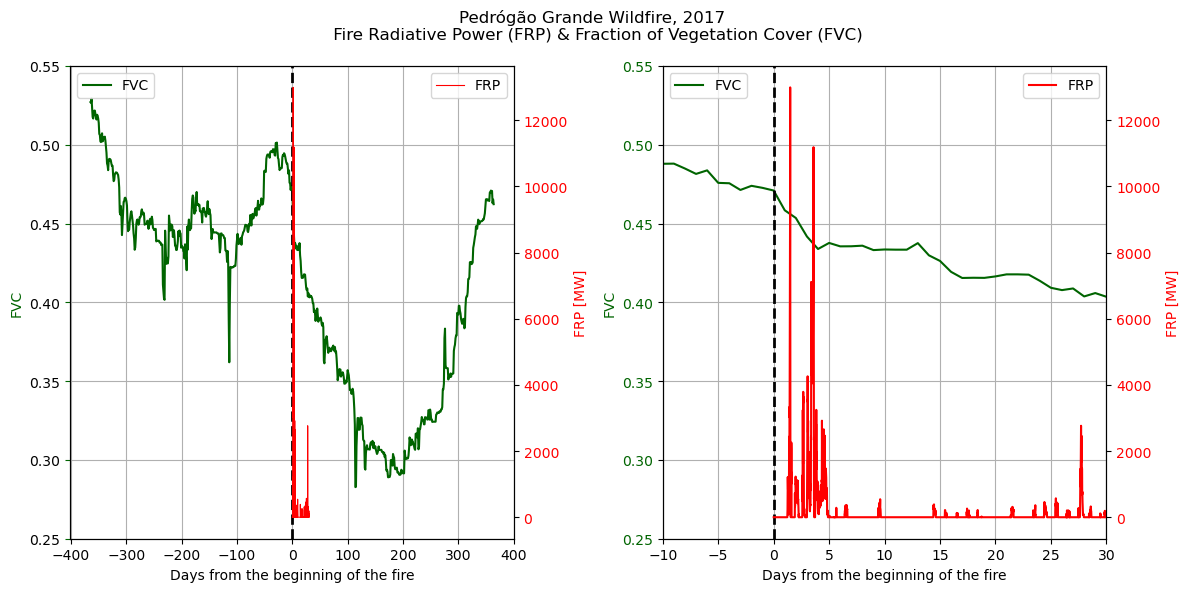

In [11]:
# Define plot colors
FVC_color="darkgreen"
FRP_color="red"

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
ax1.plot(pedrogao_x_FVC, pedrogao_y_FVC, FVC_color, label='FVC')
ax1.set_ylabel('FVC', color=FVC_color)
ax1.set_ylim(0.25, 0.55)
ax1.tick_params(axis='y', color=FVC_color)

ax1_2 = ax1.twinx()
ax1_2.plot(pedrogao_x_FRP, pedrogao_y_FRP, FRP_color, label='FRP', linewidth=0.8)
ax1_2.set_ylabel('FRP [MW]', color=FRP_color)
ax1_2.tick_params(axis='y', labelcolor=FRP_color)


# Plot data on the second subplot
ax2.plot(pedrogao_x_FVC, pedrogao_y_FVC, FVC_color, label='FVC')
ax2.set_ylabel('FVC', color=FVC_color)
ax2.set_ylim(0.25, 0.55)
ax2.tick_params(axis='y', labelcolor=FVC_color)

ax2_2 = ax2.twinx()
ax2_2.plot(pedrogao_x_FRP, pedrogao_y_FRP, FRP_color, label='FRP')
ax2_2.set_ylabel('FRP [MW]', color=FRP_color)
ax2_2.tick_params(axis='y', labelcolor=FRP_color)


# Set the first subplot
ax1.set_xlabel('Days from the beginning of the fire')
ax1.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax1.axhline(y=0, linestyle='dashed', color="grey")
ax1.grid(True)

# Set the second sublot
ax2.set_xlim(-10, 30)
ax2.set_xlabel('Days from the beginning of the fire')
ax2.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax2.axhline(y=0, linestyle='dashed', color="grey")
ax2.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax1_2.legend(loc='upper right')
ax2.legend(loc='upper left')
ax2_2.legend(loc='upper right')


plt.suptitle('Pedrógão Grande Wildfire, 2017 \n Fire Radiative Power (FRP) & Fraction of Vegetation Cover (FVC)')
plt.tight_layout()
plt.show()

We can see a clear decrease of FVC from approximately 0.47 to about 0.44 over the period of five days from the fire initiation. Afterwards, FVC keeps decreasing and it can be observed that FVC values are clearly significantly smaller over the fire-affected area the year after the wildfire in Pedrógão Grande occured.

However, this decline of FVC as observed from the MSG satellite is as pronounced only in the case of the really big Pedrógão Grande wildfire. The FVC decrease is less pronounced (i.e, barely noticeable) in the case of the other two wildfires in Covilhã, Portugal and Kras, Slovenia that were significantly smaller than the large Pedrógão Grande wildfire (see the following plot). For studying how wildfire affect vegetation, the FCI instrument on-board MTG will be indeed really helpful because of the improved spatial resolution as compared to the SEVIRI sensor.

Nevertheless, the MSG satellite-based FRPPixel offers a sufficient temporal resolution and precision to estimate the firepower and fire evolution, although the precise micro-location of the fire is not known.

All three wildfires are plotted in a similar manner as in the previous cell in the following plot.

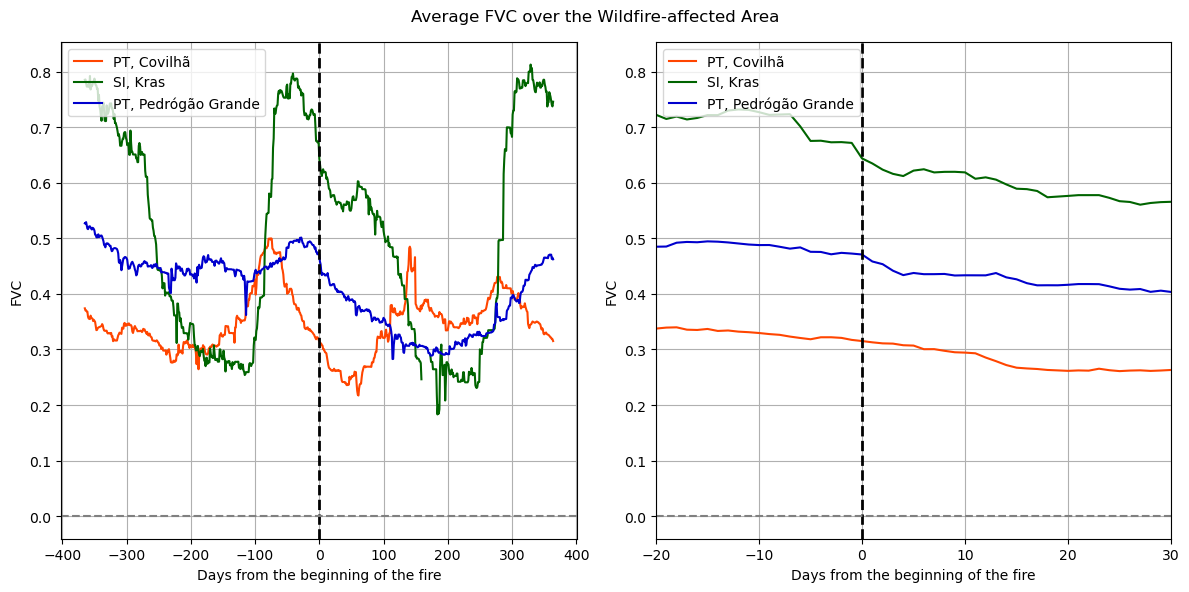

In [17]:
# Define plot colors
FVC_color="darkgreen"
FRP_color="red"

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

FVC_color="darkgreen"
FRP_color="red"



# First subplot
ax1.plot(covilha_x_FVC, covilha_y_FVC, label='PT, Covilhã', color="orangered")
ax1.plot(kras_x_FVC, kras_y_FVC, label="SI, Kras", color='darkgreen')
ax1.plot(pedrogao_x_FVC, pedrogao_y_FVC, label="PT, Pedrógão Grande", color='mediumblue')

#Second subplot
ax2.plot(covilha_x_FVC, covilha_y_FVC, label='PT, Covilhã', color="orangered")
ax2.plot(kras_x_FVC, kras_y_FVC, label="SI, Kras", color='darkgreen')
ax2.plot(pedrogao_x_FVC, pedrogao_y_FVC, label="PT, Pedrógão Grande", color='mediumblue')
ax2.set_xlim(-20, 30)

# Set the first subplot
ax1.set_ylabel('FVC')
ax1.set_xlabel('Days from the beginning of the fire')
ax1.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax1.axhline(y=0, linestyle='dashed', color="grey")
ax1.grid(True)

# Set the second subplot
ax2.set_ylabel('FVC')
ax2.set_xlabel('Days from the beginning of the fire')
ax2.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax2.axhline(y=0, linestyle='dashed', color="grey")
ax2.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.suptitle("Average FVC over the Wildfire-affected Area")
plt.tight_layout()
plt.show()

#### Conclusion

We illustrated vegetation evolution after initiation of the three European wildfires in the period from 2017 to 2022. Fire radiative power is used to determine severity and estimate the timing of the wildfire initiation.

Evolution of fraction of vegetation cover is monitored in the 30-day period after ignition. In the case of the Pedrógão Grande wildfire, the decrease of FVC can be observed even in the following years. In Pedrógão Grande the burned area was very large, therefore, the signal that points to damaged vegetation is stronger and persists longer.

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 23.2.2025
* Ribeiro, L.M., Rodrigues, A., Lucas, D. et. al. (2020) The Impact on Structures of the Pedrógão Grande Fire Complex in June 2017 (Portugal), Fire 2020, 3, 57. [doi:10.3390/fire3040057](https://doi.org/10.3390/fire3040057 )
* Slovenian Government (2022) Poročilo o ukrepanju in intervencijskih stroških gašenja požara v naravnem okolju na območju Krasa od 17. julija do 1. avgusta 2022. [http://vrs-3.vlada.si/MANDAT22/vladnagradiva.nsf/71d4985ffda5de89c12572c3003716c4/8a691ba86ac2ada4c12588c6002df3eb?OpenDocument](http://vrs-3.vlada.si/MANDAT22/vladnagradiva.nsf/71d4985ffda5de89c12572c3003716c4/8a691ba86ac2ada4c12588c6002df3eb?OpenDocument). Accesed: 23.2.2025